In [1]:
from modules import *
warnings.filterwarnings('ignore')
import sys
sys.path.append('EMS_deconv_0307/MIST/')
import ReST

Before QC: 2598 observations and 32285 genes.
Filtering spots with less than 1500 UMIs.
After QC: 2123 observations and 14036 genes.
MIST Data created in 38.25 seconds.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:31<00:00,  1.52s/it]


Epsilon 0.840 is selected in 33.74 seconds.


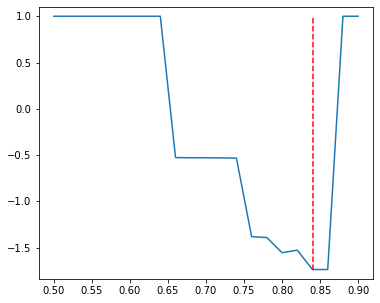

In [2]:
emt_rd = ReST.ReST('data/')

ReST_args =  {"species":"Mouse", "min_sim": 0.5, 
                            "min_region": 10, 
                              "gap":0.02,
                             "sigma": 0.4, "region_min":3,
                             "hvg_prop": 0.9, 'n_pcs':10}

emt_rd.preprocess(species=ReST_args['species'],
                  hvg_prop=ReST_args['hvg_prop'], 
                  n_pcs=ReST_args['n_pcs'])

emt_rd.extract_regions(min_sim = ReST_args['min_sim'], 
                    min_region = ReST_args['min_region'],
                    gap  = ReST_args['gap'],
                    sigma = ReST_args['sigma'],
                    region_min = ReST_args['region_min'])


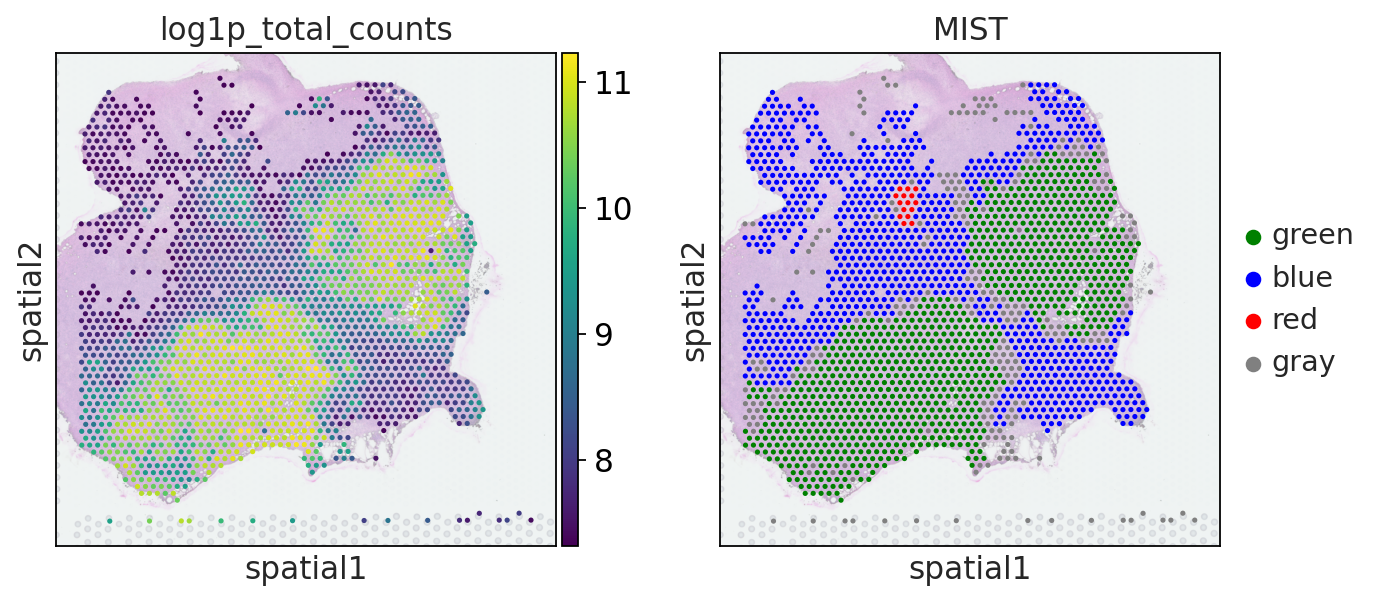

In [128]:
emt_rd.assign_region_colors({"0": "green", "1":"blue", "7": "red", "isolated": "lightgray"})
emt_rd.adata.obs['MIST'] = emt_rd.adata.obs['region_ind'].map(emt_rd.region_color_dict)
cmap = dict(zip(emt_rd.region_color_dict.values(), emt_rd.region_color_dict.values()))
sc.pl.spatial(emt_rd.adata, 
              color=['log1p_total_counts', 'MIST'], 
              wspace=0.2,
              alpha_img=0.4,
             palette=cmap,
             cmap='viridis')

In [135]:
import os

emt_rd.extract_regional_markers()
emt_rd.runGSEA()

if not os.path.exists("data/MIST"):
    os.mkdir("data/MIST")
    
emt_rd.save("data/MIST/")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:21<00:00,  7.06s/it]


Running GSEA on mode all for species Human.


In [136]:
## SAVE ReSort Reference
emt_rd.save_ReSort("data/MIST/")

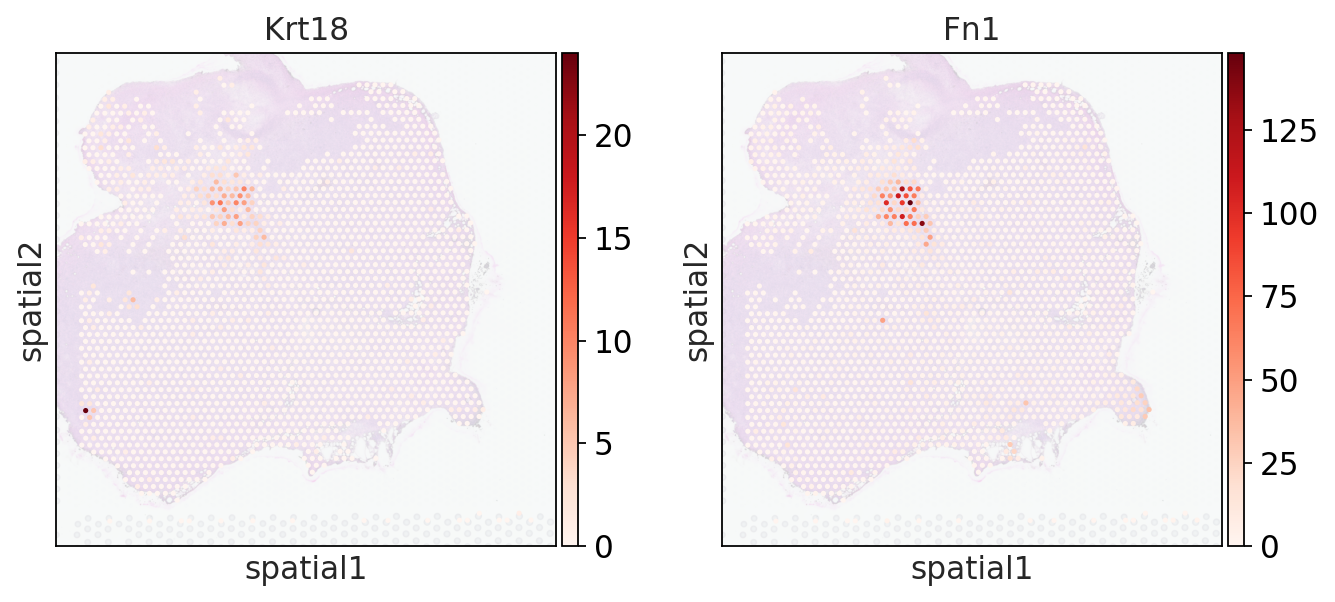

In [146]:
sc.pl.spatial(emt_rd.adata, 
              color=['Krt18', 'Fn1'], 
              wspace=0.2,
              alpha_img=0.2,
              vmin=0,
              ncols=2, 
             cmap='Reds')

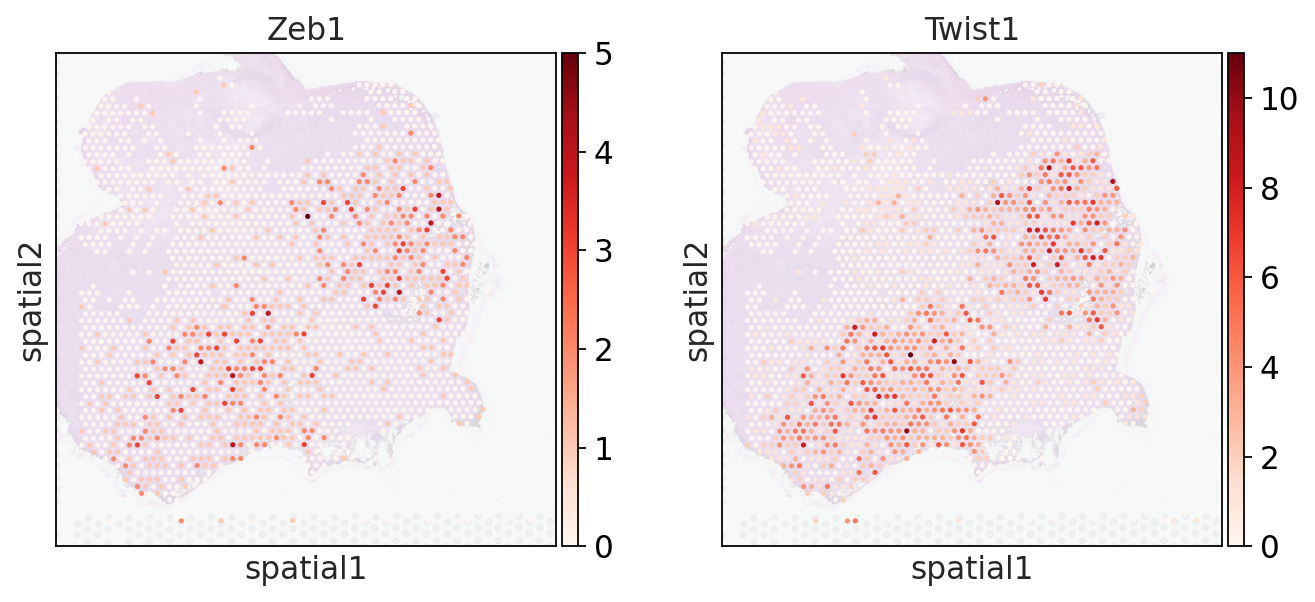

In [145]:
sc.pl.spatial(emt_rd.adata, 
              color=['Zeb1', 'Twist1'], 
              wspace=0.2,
              alpha_img=0.2,
              ncols=2, 
             cmap='Reds')

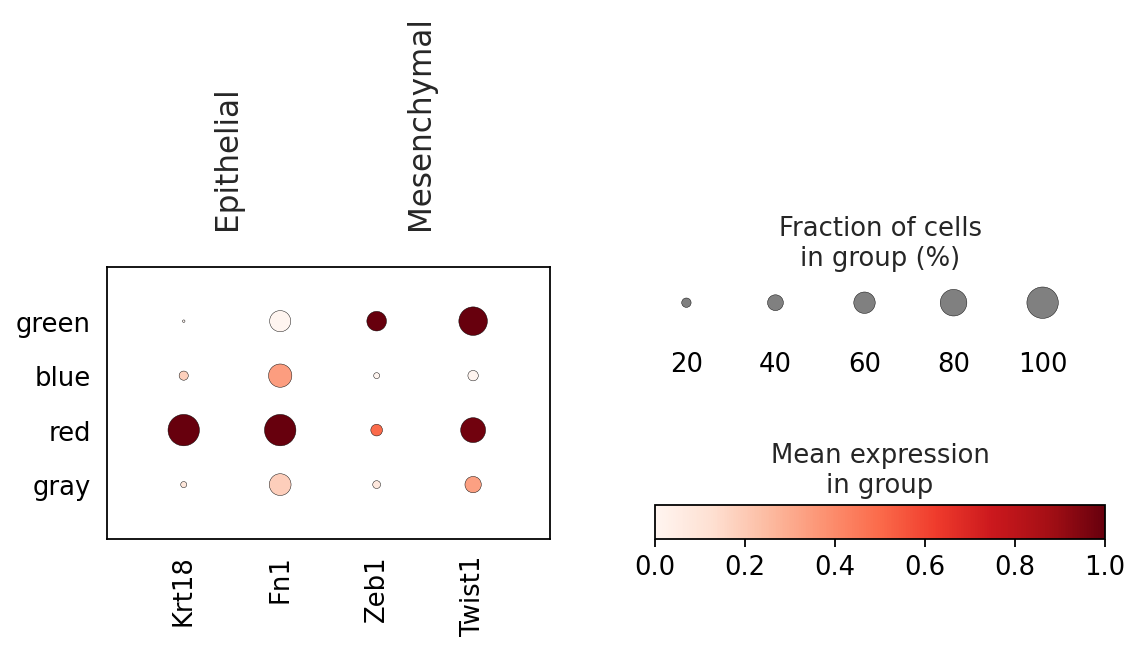

In [148]:
f, ax = plt.subplots(figsize=(8,4))
sns.set_style("white")
sc.set_figure_params(scanpy=True, fontsize=14)
markers = {'Epithelial': ['Krt18', 'Fn1'], 'Mesenchymal': ['Zeb1', 'Twist1']}
sc.pl.dotplot(emt_rd.adata, markers, groupby='MIST',
                      ax=ax,  use_raw=False, 
                    cmap='Reds', standard_scale='var', return_fig=False)

In [6]:
def extract_sig_2_regions(data, region1s, region2s):
    adata1=data[data.obs.MIST.isin(region1s), ]
    adata2=data[data.obs.MIST.isin(region2s), ]
    genes = list(set(adata1.var_names).union(set(adata2.var_names)))

    expr1 = pd.DataFrame(data=adata1.layers['CPM'].toarray(),
                        index=adata1.obs_names,
                        columns=adata1.var_names)
    expr2 = pd.DataFrame(data=adata2.layers['CPM'].toarray(),
                        index=adata2.obs_names,
                        columns=adata2.var_names)

    expr1['label'] = 'trt'
    expr2['label'] = 'ctrl'
    expr = pd.concat([expr1, expr2])
    expr.fillna(0, inplace=True)

    expr1 = expr.loc[expr.label == 'trt', genes].values
    expr2 = expr.loc[expr.label == 'ctrl', genes].values

    mean1 = np.mean(expr1, axis=0)
    mean2 = np.mean(expr2, axis=0)

    lfcs = np.log2(np.divide(mean1 + 1, mean2 + 1))
    pvals = []
    for i in trange(len(genes)):
        gex1 = np.ravel(expr1[:, i])
        gex2 = np.ravel(expr2[:, i])
        pval = ranksums(gex1, gex2)[1]
        pvals.append(pval)
    padjs = multipletests(pvals)[1]
    deg_df = pd.DataFrame({'gene': genes,'lfc': lfcs, 'pval': pvals, 'padj': padjs})
    deg_df = deg_df.loc[(np.absolute(deg_df.lfc) > 0.26) & (deg_df.padj <= 0.01)]
    deg_df = deg_df.sort_values("lfc", ascending=False)
    return deg_df

In [21]:
blue_degs = extract_sig_2_regions(emt_rd.adata, region1s=['blue'], region2s=['green', 'red'])
#blue_degs = blue_degs.loc[blue_degs.lfc > 0.58]
blue_degs.shape

  0%|          | 0/14036 [00:00<?, ?it/s]

(5173, 4)

In [41]:
import gseapy as gp

enrichr_res = gp.enrichr(blue_degs.loc[blue_degs.lfc>0.57,
                                           'gene'].tolist(), 
                         gene_sets= ['KEGG_2019_Mouse', 'GO_Biological_Process_2021',
                                     'GO_Cellular_Components_2021', 'GO_Molecular_Function_2021'])

In [131]:
enrichr_res_df = enrichr_res.results
enrichr_res_df = enrichr_res_df.loc[enrichr_res_df['Adjusted P-value'] <= 0.01,:]

In [44]:
res_top5 = []

for gs in set(enrichr_res_df.Gene_set):
    df = enrichr_res_df.loc[enrichr_res_df.Gene_set==gs,:]
    df = df.sort_values("Combined Score", ascending=False).iloc[:5,:]
    res_top5.append(df)

res_top5 = pd.concat(res_top5)

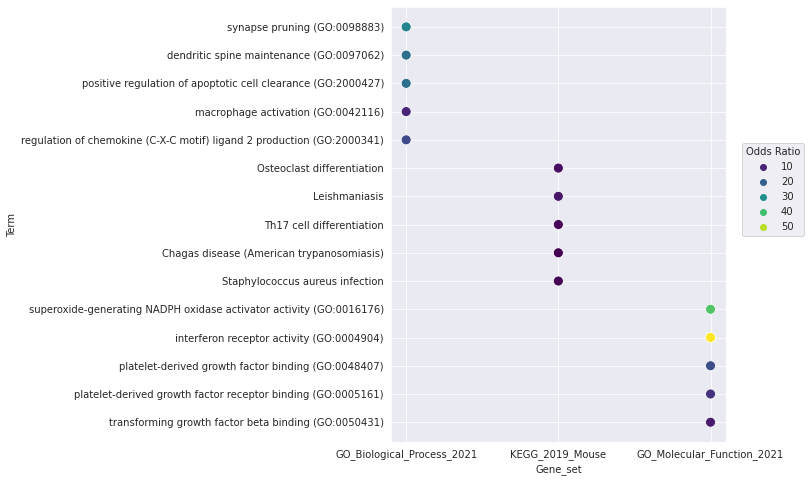

In [65]:
plt.figure(figsize=(6,8))
sns.set_style("darkgrid")
sns.scatterplot(data=res_top5, x='Gene_set', 
                y='Term', 
                hue='Odds Ratio', 
                s=100,
               palette='viridis')

plt.legend(bbox_to_anchor=(1.25, 0.7), title='Odds Ratio')